In [2]:
import pandas as pd
import warnings
import sys
from pathlib import Path
import importlib

# Add project root to Python path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

# Now import app modules
import app.data as data
import app.charts as charts
import app.views as views

importlib.reload(data)
importlib.reload(charts)
importlib.reload(views)

import warnings
warnings.filterwarnings('ignore')


2025-10-15 22:17:29.733 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-15 22:17:29.734 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-15 22:17:30.057 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-15 22:17:30.058 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [3]:
# Load datasets

(df_geo, 
df_order, 
df_order_item, 
df_order_payment, 
df_order_review,
df_product, 
df_seller, 
df_customer, 
df_product_category) = data.load_raw_data()


2025-10-15 22:17:30.062 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-15 22:17:30.063 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 22:17:30.107 
  command:

    streamlit run /opt/anaconda3/lib/python3.13/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-10-15 22:17:30.108 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 22:17:30.108 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 22:17:30.613 Thread 'Thread-5': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 22:17:30.614 Thread 'Thread-5': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 22:17:30.987 Thread 'MainThread': missing

# Investigate Missing Values

In [4]:
"""
Find nulls
"""
nulls_geo = df_geo.loc[:,(df_geo.isna().sum() > 0).values]
nulls_orders = df_order.loc[:,(df_order.isna().sum() > 0).values]
nulls_order_item = df_order_item.loc[:,(df_order_item.isna().sum() > 0)]
nulls_order_payment = df_order_payment.loc[:,(df_order_payment.isna().sum() > 0)]
nulls_order_review = df_order_review.loc[:,(df_order_review.isna().sum() > 0)]
nulls_product = df_product.loc[:,(df_product.isna().sum() > 0)]
nulls_seller = df_seller.loc[:,(df_seller.isna().sum() > 0)]
nulls_product_category = df_product_category.loc[:,(df_product_category.isna().sum() > 0)]
nulls_customer = df_customer.loc[:,(df_customer.isna().sum() > 0)]

print("------Nulls------")
print("Geolocation: ", nulls_geo.shape[1] > 1)
print("Orders: ",nulls_orders.shape[1] > 1)
print("Order Item: ",nulls_order_item.shape[1] > 1)
print("Order Payment: ",nulls_order_payment.shape[1] > 1)
print("Order Review: ",nulls_order_review.shape[1] > 1)
print("Product: ",nulls_product.shape[1] > 1)
print("Seller: ",nulls_seller.shape[1] > 1)
print("Product Category: ",nulls_product_category.shape[1] > 1)
print("Customer: ",nulls_customer.shape[1] > 1)


------Nulls------
Geolocation:  False
Orders:  True
Order Item:  False
Order Payment:  False
Order Review:  True
Product:  True
Seller:  False
Product Category:  False
Customer:  False


- *Orders*, *Order Review*, and *Product* tables have null values

In [5]:
"""
Visualize missing values in Orders table
"""
charts.missingness_heatmap(df_order)

<Figure size 1000x1000 with 1 Axes>

**Observation:** Missing values cluster around 'order_delivered_customer_date' and 'order_delivered_carrier_date', with some in 'order_approved_at'

**Next Steps:** Investigate missing values

## Investigate nulls in 'order_delivered_customer_date' and 'order_delivered_carrier_date'

In [10]:
"""
Features: Order Purchase Date, Delivery Null Count
"""

df_order = data.convert_to_datetime(df_order)

df_order = data.add_date_features(df_order)

customer_all, carrier_all = views.get_delivery_nulls(df_order)

customer_nulls_chart, carrier_nulls_chart = charts.delivery_nulls_chart(df_order)

customer_nulls_chart | carrier_nulls_chart




alt.HConcatChart(...)

**Observation:** Missing values show a mild, gradual increase through the year, with a slight uptick coinciding with major spikes in total orders in around Jan 2018. 

**Hypothesis:** The increase in missing values is possibly due to the increase in orders, leading to an increase in cancellations, resulting in missing values in delivery dates.

**Next Step:** Check for a rise in cancelled orders during these high-volume periods to validate this hypothesis and inform imputation strategy.

In [7]:
"""
Show cancelled orders by date
"""
chart = charts.cancellation_chart(df_order)
chart


alt.Chart(...)

**Observation:** Cancelled orders spike in Jan 2018. This finding supports the hypothesis that an increase in missing delivery values is due to a increased purchases, resulting in more cancellations. 
**Next Step:** Impute delivery time.

## Impute Delivery Times

In [69]:
"""
Impute Delivery Dates
"""
df_order = data.impute_delivery_dates(df_order)


## Investigate missing values in 'order_approved_at'

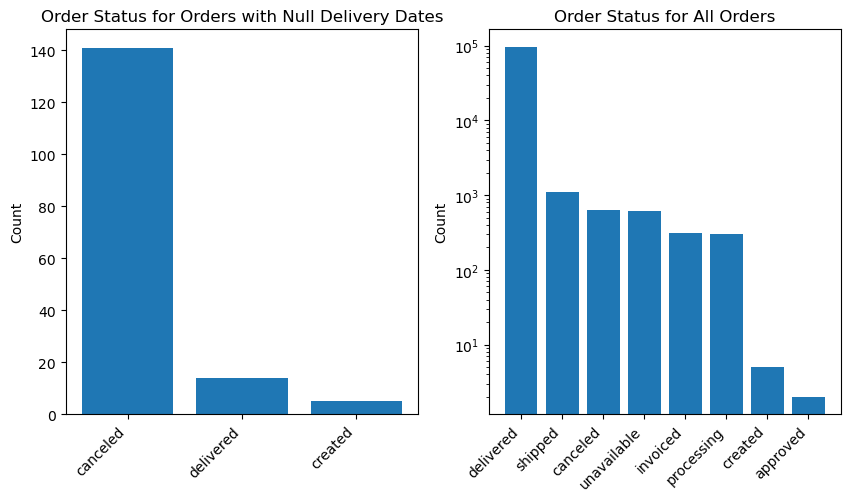

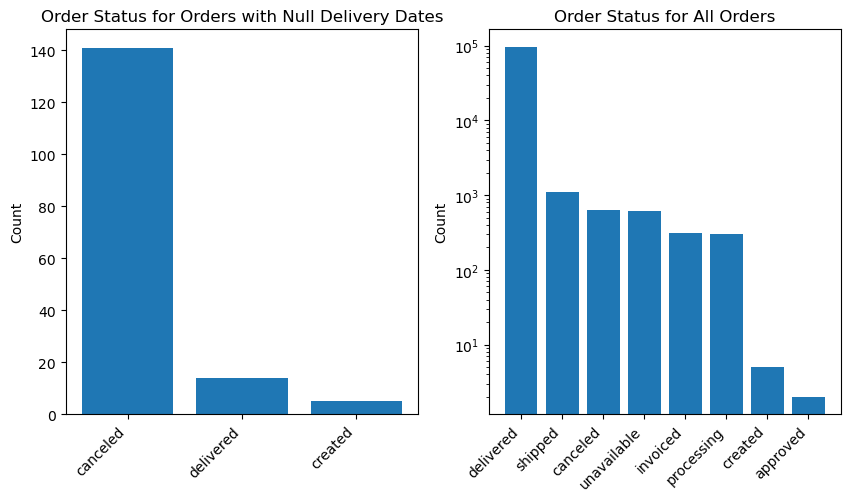

In [70]:
"""
Determining null values in 'order_approved_at' column
"""

charts.order_approved_at_nulls_chart(df_order)



**Observation:** Sales with null delivery dates have disproportionately high cancellations when compared to order status of entire dataset. 

**Hypothesis:** These missing values are likely not missing at random (MNAR), but instead are due to the system's handling of canceled orders, which may skip the approval step.

**Recommendation:** Investigate the order approval and cancellation workflow to confirm if the process intentionally omits "order_approved_at" for canceled orders.


# Feature Engineering

## Discretize Purchasing Power

In [72]:
"""
Discretize Customer Spending
"""

df_customer = data.add_customer_spending(df_customer, df_order, df_order_payment)



## Add Regions Feature and Encode

In [ ]:
"""Add Column for Region in Customer and Geolocation datasets"""


df_customer['customer_region'] = df_customer['customer_state'].map(data.state_to_region)
df_geo['geolocation_region'] = df_geo['geolocation_state'].map(data.state_to_region)




In [ ]:
"""
Merge Product Category Name Translation with Product Dataset
"""
df_product = data.merge_product_category(df_product, df_product_category)

In [36]:
from sklearn.preprocessing import OneHotEncoder
"""
One Hot Encode Region in Customer Dataset
"""

# Encode Region
encoder = OneHotEncoder()
one_hot_region = encoder.fit_transform(df_customer[['customer_region']])
one_hot_region_df = pd.DataFrame(one_hot_region.toarray(), columns=encoder.get_feature_names_out())
df_customer = pd.concat([df_customer, one_hot_region_df], axis=1)

encoder = OneHotEncoder()
one_hot_product_category = encoder.fit_transform(df_product[['product_category_name']])
one_hot_product_category_df = pd.DataFrame(one_hot_product_category.toarray(), columns=encoder.get_feature_names_out())
df_product = pd.concat([df_product, one_hot_product_category_df], axis=1)

encoder = OneHotEncoder()
one_hot_seller_city = encoder.fit_transform(df_seller[['seller_city']])
one_hot_seller_city_df = pd.DataFrame(one_hot_seller_city.toarray(), columns=encoder.get_feature_names_out())
df_seller = pd.concat([df_seller, one_hot_seller_city_df], axis=1)



# Output

In [37]:
# Processed Data
df_order.to_csv('./data/processed/orders.csv', index=False)
df_customer.to_csv('./data/processed/customers.csv', index=False)
df_geo.to_csv('./data/processed/geolocation.csv', index=False)
df_order_item.to_csv('./data/processed/order_items.csv', index=False)
df_order_payment.to_csv('./data/processed/order_payments.csv', index=False)
df_order_review.to_csv('./data/processed/order_reviews.csv', index=False)
df_product.to_csv('./data/processed/products.csv', index=False)
df_seller.to_csv('./data/processed/sellers.csv', index=False)
df_product_category.to_csv('./data/processed/product_category.csv', index=False)


